<a href="https://colab.research.google.com/github/edwardj4747/Dataset-Labeling/blob/master/ML_notebooks/LSTM_Aura_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from keras.preprocessing import sequence

from google.colab import files
from tqdm import tqdm

from numpy.random import seed
seed(1)
tf.random.set_seed(2)

Load in the data

In [ ]:
import json
with open('/content/sample_data/Feb24_int_encoded_miv_plus_version_243_papers_119_words.json') as f:
  encoded_sentence_list = json.load(f)

y = np.load('/content/sample_data/Feb24_ML2xx_num_datasets_9_papers_243.npy')

In [ ]:
len(encoded_sentence_list), y.shape

(243, (243, 9))

plot a histogram of sentence length

In [ ]:
from collections import Counter
from matplotlib import pyplot as plt

In [ ]:
counter = Counter([len(s) for s in encoded_sentence_list])

In [ ]:
counter.keys(), counter.values()

(dict_keys([179, 157, 188, 240, 115, 152, 90, 263, 100, 159, 74, 88, 209, 60, 140, 183, 142, 338, 104, 326, 215, 258, 156, 184, 164, 108, 50, 32, 770, 124, 212, 46, 127, 6, 138, 103, 118, 257, 204, 107, 385, 427, 75, 222, 117, 211, 94, 193, 83, 16, 102, 78, 68, 97, 226, 221, 235, 92, 141, 191, 302, 37, 201, 114, 69, 33, 213, 198, 143, 328, 85, 976, 80, 200, 158, 27, 295, 162, 53, 365, 121, 219, 278, 65, 315, 7, 76, 236, 178, 126, 272, 383, 167, 79, 174, 423, 611, 428, 335, 35, 165, 38, 12, 755, 132, 297, 98, 110, 14, 82, 23, 26, 231, 206, 218, 43, 430, 255, 331, 269, 10, 39, 63, 316, 237, 146, 40, 67, 389, 207, 149, 112, 344, 224, 131, 345, 440, 932, 45, 177, 109, 151, 125, 22, 239, 246, 77, 28, 320, 541, 173, 318, 54, 214, 15, 285, 21, 84, 51, 319, 245, 419, 270, 464, 252, 89, 129, 262, 57, 552, 838, 47, 13, 44, 366, 403, 70, 96, 361, 283, 228]),
 dict_values([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 3, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 

<BarContainer object of 181 artists>

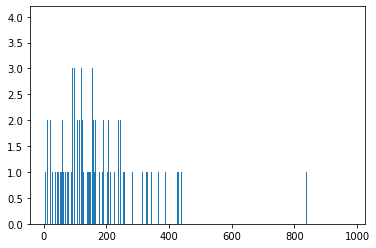

In [ ]:
plt.bar(counter.keys(), counter.values())  # minimum is 6

In [ ]:
# really dumb way to find the input size
current_max = 0
for es in encoded_sentence_list:
  for value in es:
    if value > current_max:
      current_max = value

current_max

119

In [ ]:
sequence_length = 250

In [ ]:
train_test_split = int(0.2 * len(encoded_sentence_list))
X_test, X_train = encoded_sentence_list[:train_test_split], encoded_sentence_list[train_test_split:]
y_test, y_train = y[:train_test_split, :], y[train_test_split:, :]

In [ ]:
# truncate and pad input sequences
X_train = sequence.pad_sequences(X_train, maxlen=sequence_length)
X_test = sequence.pad_sequences(X_test, maxlen=sequence_length)

# convert Xs into numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

X_test.shape, X_train.shape

((48, 250), (195, 250))

In [ ]:
embedding_vector_length = 50
d1_rate = 0.1
lstm_units = 400
d2_rate = 0.5
model=None
model = Sequential(
    [
     layers.Embedding(input_dim=current_max, output_dim=embedding_vector_length, input_length=sequence_length, name = f"Ebd_VS_{embedding_vector_length}_input_{sequence_length}"),
     layers.Dropout(d1_rate, name=f'Dropout_{int(d1_rate *10)}'),
     layers.LSTM(lstm_units, name= f"LSTM_{lstm_units}"),
     layers.Dropout(d2_rate, name = f"Dropout_{int(d2_rate *10)}"),
     layers.Dense(9, activation='sigmoid', name='Dense_Out')
    ]
)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Ebd_VS_50_input_250 (Embeddi (None, 250, 50)           5950      
_________________________________________________________________
Dropout_1 (Dropout)          (None, 250, 50)           0         
_________________________________________________________________
LSTM_400 (LSTM)              (None, 400)               721600    
_________________________________________________________________
Dropout_5 (Dropout)          (None, 400)               0         
_________________________________________________________________
Dense_Out (Dense)            (None, 9)                 3609      
Total params: 731,159
Trainable params: 731,159
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy', 'Precision', 'Recall'])

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)

In [ ]:
num_epochs=15000
history=None
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[early_stopping], epochs=num_epochs, verbose=2)

In [ ]:
model.evaluate(X_test, y_test)  # should be the higest numbers because restored training weights

2/2 [==============================] - 0s 20ms/step - loss: 0.2468 - accuracy: 0.7500 - precision: 0.7018 - recall: 0.6061


[0.24678730964660645, 0.75, 0.7017543911933899, 0.6060606241226196]

In [ ]:
print(history.history['precision'][-1])
print(history.history['recall'][-1])
print(history.history['val_precision'][-1])
print(history.history['val_recall'][-1])

0.9309210777282715
0.9129032492637634
0.6086956262588501
0.6363636255264282


In [ ]:
# create an array with precision, recall, val_precision, val_recall
params_array = np.array([history.history['precision'], history.history['recall'], history.history['val_precision'], history.history['val_recall']])
params_array.shape

(4, 177)

##### Alternative methods for where to draw the line

In [ ]:
# find the best epoch by maxing the sum of the four
sums = np.sum(params_array, axis=0)
good_stopping_point = np.argmax(sums)
values_gsp = params_array[:, good_stopping_point]
np.argmax(sums), sums[np.argmax(sums)], params_array[:, np.argmax(sums)] 

(140,
 2.852076768875122,
 array([0.82222223, 0.716129  , 0.64705884, 0.66666669]))

In [ ]:
# best epoch by weighing validation a little bit larger
array_param_scaled = params_array * np.array([0.5, 0.5, 1, 1]).reshape(-1, 1)
aps_sum = np.sum(array_param_scaled, axis=0)
good_stopping_point = np.argmax(aps_sum)
values_gsp = params_array[:, good_stopping_point]
good_stopping_point, aps_sum[good_stopping_point], params_array[:, good_stopping_point]

(140,
 2.0829011499881744,
 array([0.82222223, 0.716129  , 0.64705884, 0.66666669]))

##### Draw the line based on highest possible F1 validation score

In [ ]:
# by best f1 score for validation
f1 = 2 * params_array[2, :] * params_array[3, :] / (params_array[2, :] + params_array[3, :]  + 1e-12)
highest_f1_index = np.argmax(f1)

good_stopping_point = highest_f1_index
values_gsp = params_array[:, good_stopping_point]

highest_f1_index, f1[highest_f1_index]

(122, 0.6942148642101531)

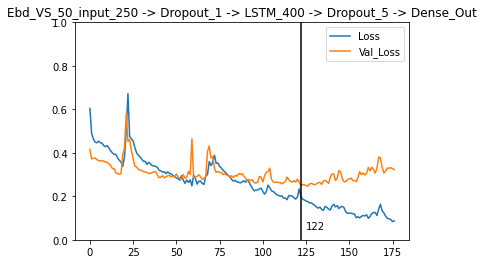

In [ ]:
string = [l.name for l in model.layers]
plot_title = ' -> '.join(string)
 

plt.plot( history.history['loss'], label="Loss")
plt.plot( history.history['val_loss'], label="Val_Loss")
plt.plot([good_stopping_point, good_stopping_point], [0, 1], color='black')
plt.annotate(str(good_stopping_point), xy=(good_stopping_point + 3, .05))
plt.ylim((0, 1))
plt.title(plot_title)
plt.savefig("ml_results/" + plot_title + "_loss")
plt.legend()
plt.show()

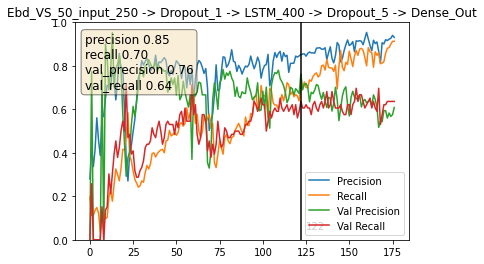

In [ ]:
fig, ax = plt.subplots()
plt.plot(history.history['precision'], label="Precision")
plt.plot(history.history['recall'], label="Recall")
plt.plot(history.history['val_precision'], label="Val Precision")
plt.plot(history.history['val_recall'], label="Val Recall")
plt.plot([good_stopping_point, good_stopping_point], [0, 1], color='black')
plt.annotate(str(good_stopping_point), xy=(good_stopping_point + 3, .05))
plt.title(plot_title)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

textstr = f"precision {values_gsp[0]:.2f}\nrecall {values_gsp[1]:.2f}\nval_precision {values_gsp[2]:.2f}\nval_recall {values_gsp[3]:.2f}"
# place a text box in upper left in axes coords
ax.text(0.03, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.ylim((0, 1))
plt.legend()
plt.savefig("ml_results/" + str(plot_title))
plt.show()

# Create loop to try a bunch of models

In [ ]:
def test_model(embedding_vector_length = 10, d1_rate = 0.1, lstm_units = 10, d2_rate = 0.5, early_stopping = keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)):
  # create the model
  model=None
  model = Sequential(
    [
     layers.Embedding(input_dim=current_max, output_dim=embedding_vector_length, input_length=sequence_length, name = f"Ebd_VS_{embedding_vector_length}_input_{sequence_length}"),
     layers.Dropout(d1_rate, name=f'Drop1_{int(d1_rate *100)}'),
     layers.LSTM(lstm_units, name= f"LSTM_{lstm_units}"),
     layers.Dropout(d2_rate, name = f"Drop2_{int(d2_rate *100)}"),
     layers.Dense(9, activation='sigmoid', name='Dense_Out')
    ]
  )

  model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy', 'Precision', 'Recall'])

  num_epochs=15000
  history=None
  history = model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[early_stopping], epochs=num_epochs, verbose=0)

  # name of the model
  string = [l.name for l in model.layers]
  plot_title = ' -> '.join(string)

  # save the model
  model.save('ml_results/models/' + plot_title)

  # save the history
  with open('ml_results/history/' + plot_title + ".json", 'w', encoding='utf-8') as f:
    json.dump(history.history, f, indent=4)

  # create an (4, epoch) array with precision, recall, val_precision, val_recall
  params_array = np.array([history.history['precision'], history.history['recall'], history.history['val_precision'], history.history['val_recall']])
  
  # by best f1 score for validation
  f1 = 2 * params_array[2, :] * params_array[3, :] / (params_array[2, :] + params_array[3, :]  + 1e-12)
  highest_f1_index = np.argmax(f1)

  good_stopping_point = highest_f1_index
  values_gsp = params_array[:, good_stopping_point]

  highest_f1_index, f1[highest_f1_index]
  

  # create loss plot
  plt.plot( history.history['loss'], label="Loss")
  plt.plot( history.history['val_loss'], label="Val_Loss")
  plt.plot([good_stopping_point, good_stopping_point], [0, 1], color='black')
  plt.annotate(str(good_stopping_point), xy=(good_stopping_point + 3, .05))
  plt.ylim((0, 1))
  plt.title(plot_title)
  plt.savefig("ml_results/images/" + plot_title + "_loss")
  plt.legend()
  # plt.show()

  # create precision/recall plot
  fig, ax = plt.subplots()
  plt.plot(history.history['precision'], label="Precision")
  plt.plot(history.history['recall'], label="Recall")
  plt.plot(history.history['val_precision'], label="Val Precision")
  plt.plot(history.history['val_recall'], label="Val Recall")
  plt.plot([good_stopping_point, good_stopping_point], [0, 1], color='black')
  plt.annotate(str(good_stopping_point), xy=(good_stopping_point + 3, .05))
  plt.title(plot_title)

  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

  textstr = f"precision {values_gsp[0]:.2f}\nrecall {values_gsp[1]:.2f}\nval_precision {values_gsp[2]:.2f}\nval_recall {values_gsp[3]:.2f}"
  # place a text box in upper left in axes coords
  ax.text(0.03, 0.95, textstr, transform=ax.transAxes, fontsize=12,
          verticalalignment='top', bbox=props)
  plt.ylim((0, 1))
  plt.legend()
  plt.savefig("ml_results/images/" + str(plot_title))
  # plt.show()

  return [plot_title, history.history['precision'][-1], history.history['recall'][-1], history.history['val_precision'][-1], history.history['val_recall'][-1]]

In [ ]:
lstm_range = np.arange(2, 61)
vs_range = np.arange(8, 64, 2)
dropout_range = np.arange(0.05, 0.86, 0.05)

  0%|          | 0/59 [00:00<?, ?it/s]WARNING:absl:Found untraced functions such as lstm_cell_11_layer_call_fn, lstm_cell_11_layer_call_and_return_conditional_losses, lstm_cell_11_layer_call_fn, lstm_cell_11_layer_call_and_return_conditional_losses, lstm_cell_11_layer_call_and_return_conditional_losses while saving (showing 5 of 5). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_5 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_5 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_10 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_10 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_15 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_15 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_20 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_20 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_25 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_25 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_30 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_30 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_35 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_35 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_40 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_40 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_45 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_45 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_50 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_50 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_55 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_55 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_60 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_60 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_65 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_65 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_70 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_70 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_75 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_75 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_80 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_80 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_85 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_5 -> LSTM_2 -> Drop2_85 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_5 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_5 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_10 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_10 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_15 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_15 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_20 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_20 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_25 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_25 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_30 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_30 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_35 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_35 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_40 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_40 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_45 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_45 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_50 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_50 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_55 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_55 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_60 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_60 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_65 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_65 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_70 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_70 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_75 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_75 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_80 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_80 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_85 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_10 -> LSTM_2 -> Drop2_85 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_5 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_5 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_10 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_10 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_15 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_15 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_20 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_20 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_25 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_25 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_30 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_30 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_35 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_35 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_40 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_40 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_45 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_45 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_50 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_50 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_55 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_55 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_60 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_60 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_65 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_65 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_70 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_70 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_75 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_75 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_80 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_80 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_85 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_15 -> LSTM_2 -> Drop2_85 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_5 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_5 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_10 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_10 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_15 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_15 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_20 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_20 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_25 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_25 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_30 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_30 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_35 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_35 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_40 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_40 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_45 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_45 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_50 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_50 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_55 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_55 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_60 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_60 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_65 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_65 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_70 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_70 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_75 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_75 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_80 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_80 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_85 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_20 -> LSTM_2 -> Drop2_85 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_5 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_5 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_10 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_10 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_15 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_15 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_20 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_20 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_25 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_25 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_30 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_30 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_35 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_35 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_40 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_40 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_45 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_45 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_50 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_50 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_55 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_55 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_60 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_60 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_65 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_65 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_70 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_70 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_75 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_75 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_80 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_80 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_85 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_25 -> LSTM_2 -> Drop2_85 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_5 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_5 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_10 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_10 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_15 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_15 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_20 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_20 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_25 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_25 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_30 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_30 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_35 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_35 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_40 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_40 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_45 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_45 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_50 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_50 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_55 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_55 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_60 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_60 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_65 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_65 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_70 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_70 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_75 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_75 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_80 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_80 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_85 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_30 -> LSTM_2 -> Drop2_85 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_5 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_5 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_10 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_10 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_15 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_15 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_20 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_20 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_25 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_25 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_30 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_30 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_35 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_35 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_40 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_40 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_45 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_45 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_50 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_50 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_55 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_55 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_60 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_60 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_65 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_65 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_70 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_70 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_75 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_75 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_80 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_80 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_85 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_35 -> LSTM_2 -> Drop2_85 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_40 -> LSTM_2 -> Drop2_5 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_40 -> LSTM_2 -> Drop2_5 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_40 -> LSTM_2 -> Drop2_10 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_40 -> LSTM_2 -> Drop2_10 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_40 -> LSTM_2 -> Drop2_15 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_40 -> LSTM_2 -> Drop2_15 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_40 -> LSTM_2 -> Drop2_20 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_40 -> LSTM_2 -> Drop2_20 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_40 -> LSTM_2 -> Drop2_25 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_40 -> LSTM_2 -> Drop2_25 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_40 -> LSTM_2 -> Drop2_30 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_40 -> LSTM_2 -> Drop2_30 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_40 -> LSTM_2 -> Drop2_35 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_40 -> LSTM_2 -> Drop2_35 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_40 -> LSTM_2 -> Drop2_40 -> Dense_Out/assets


INFO:tensorflow:Assets written to: ml_results/models/Ebd_VS_8_input_250 -> Drop1_40 -> LSTM_2 -> Drop2_40 -> Dense_Out/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


KeyboardInterrupt: ignored

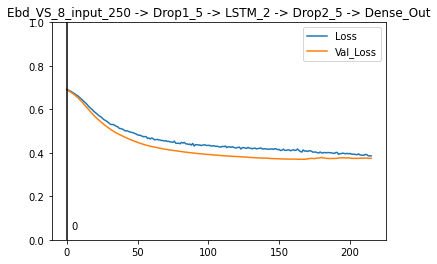

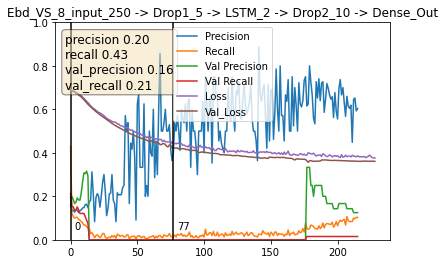

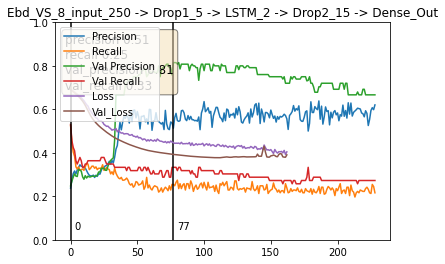

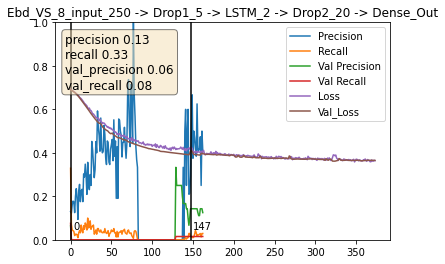

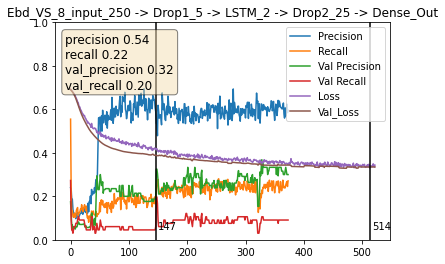

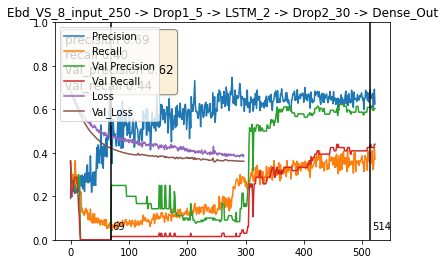

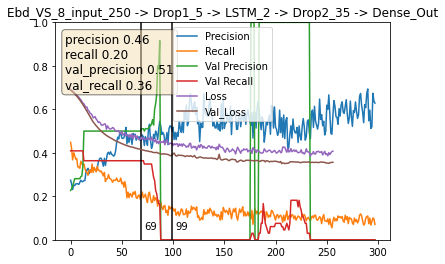

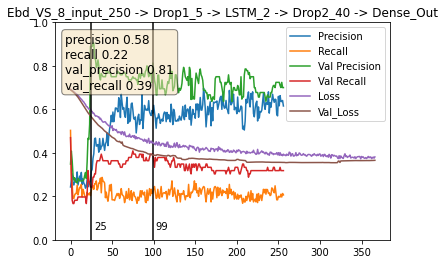

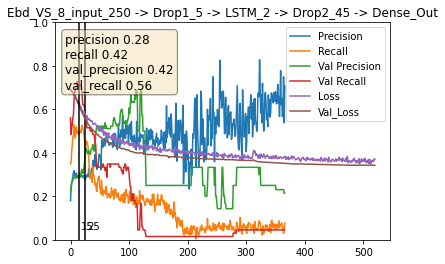

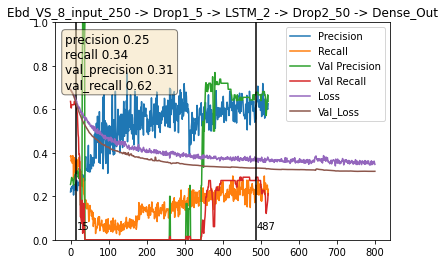

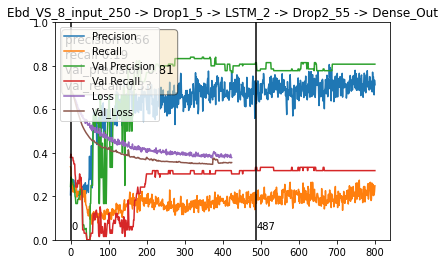

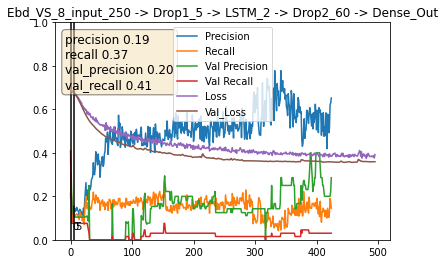

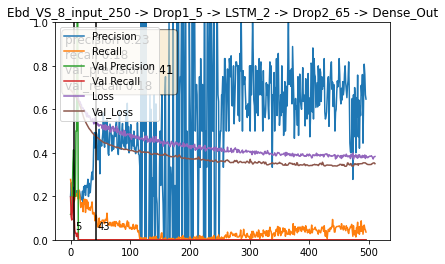

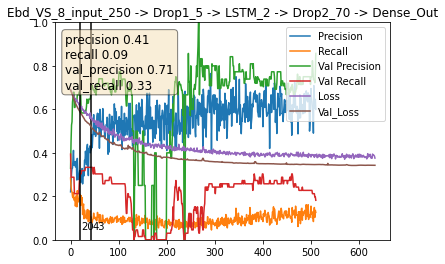

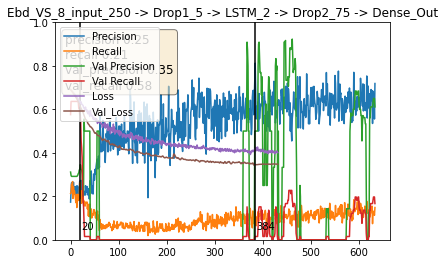

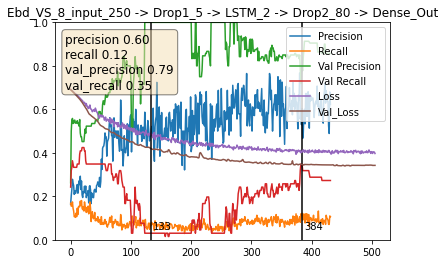

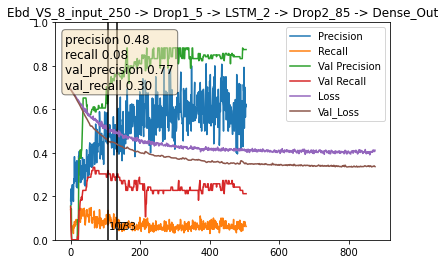

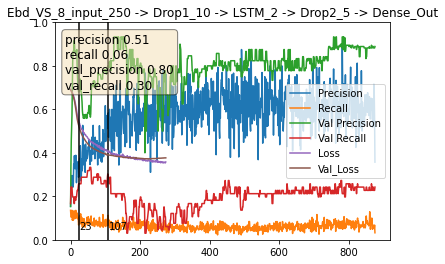

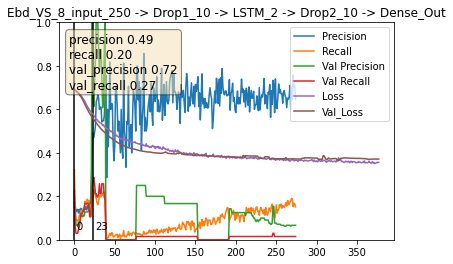

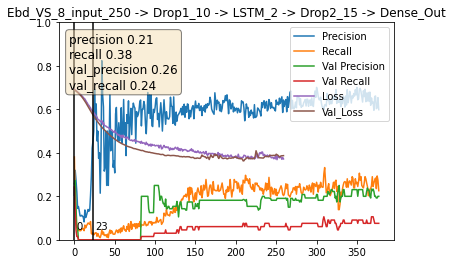

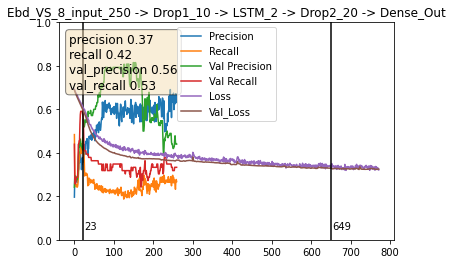

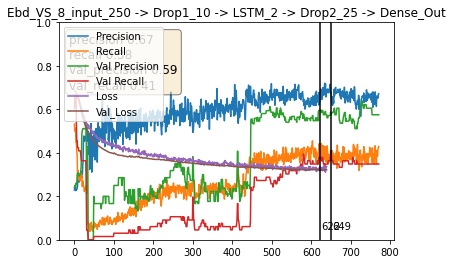

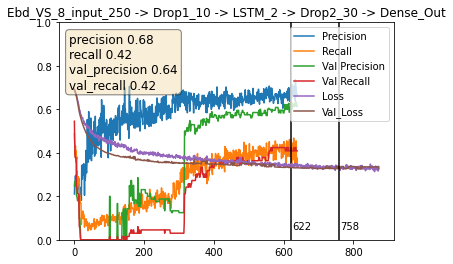

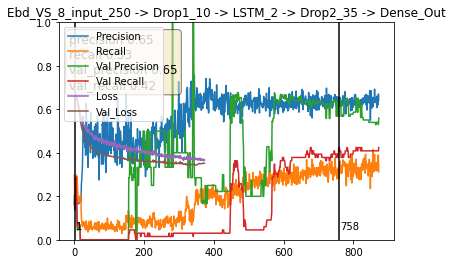

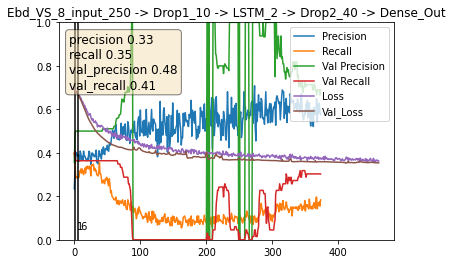

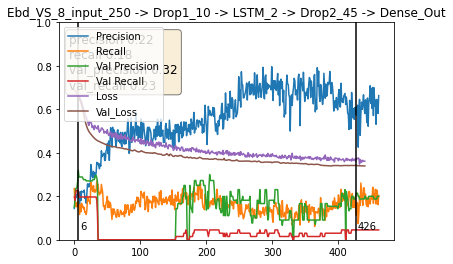

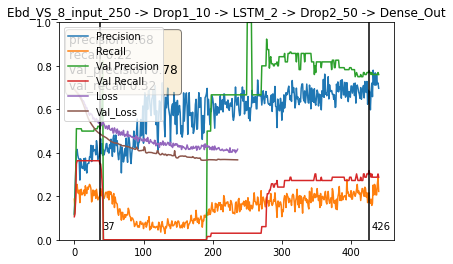

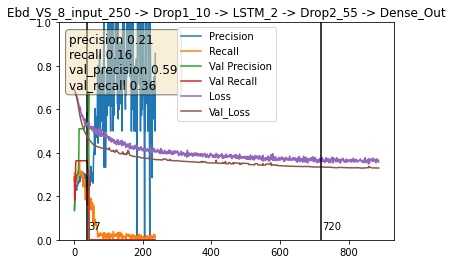

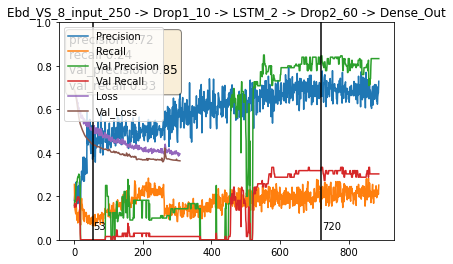

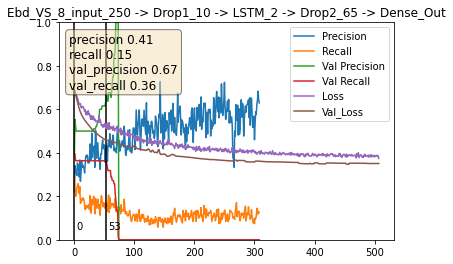

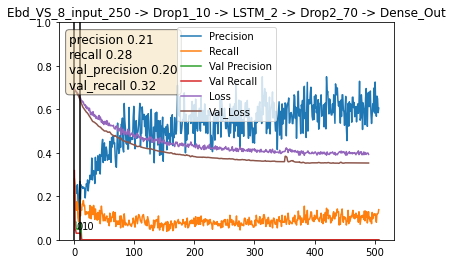

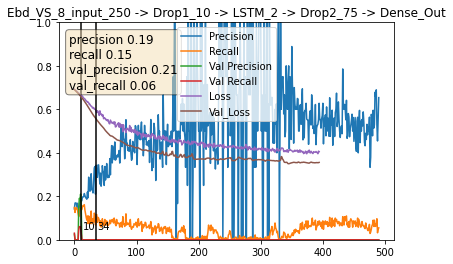

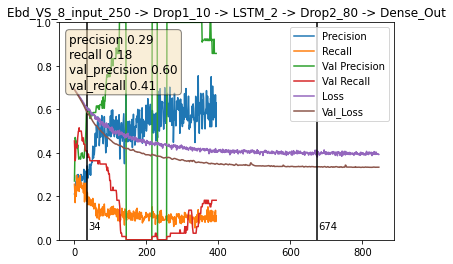

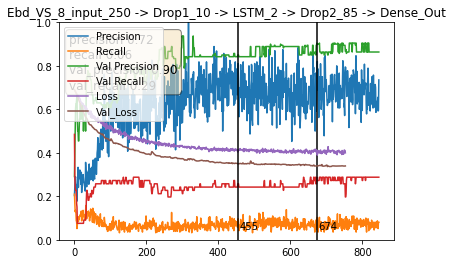

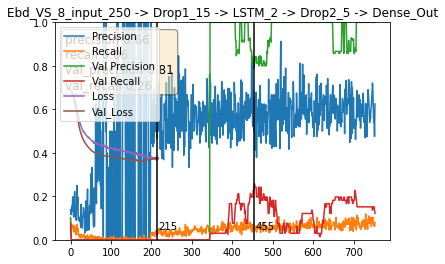

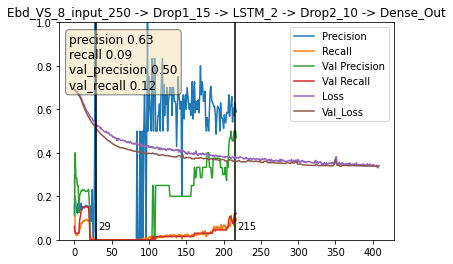

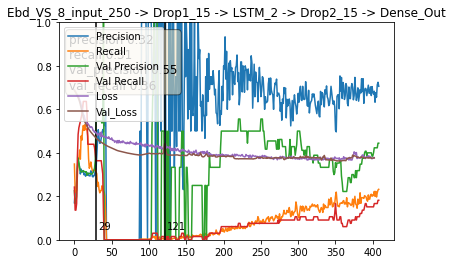

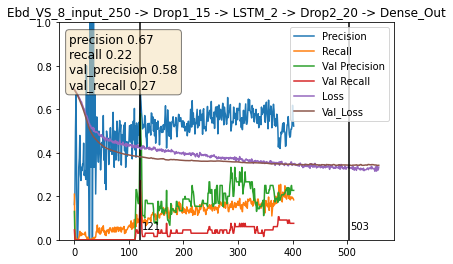

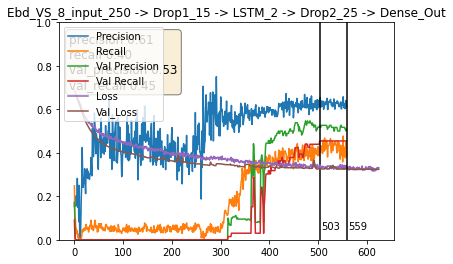

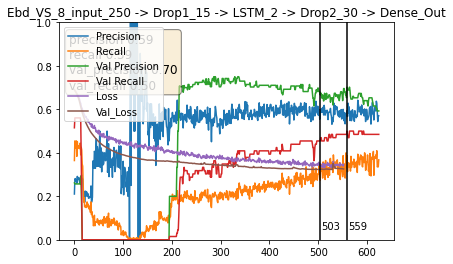

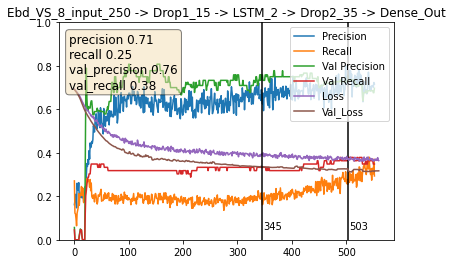

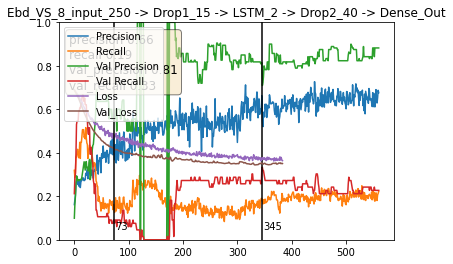

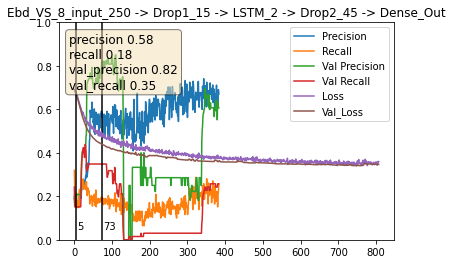

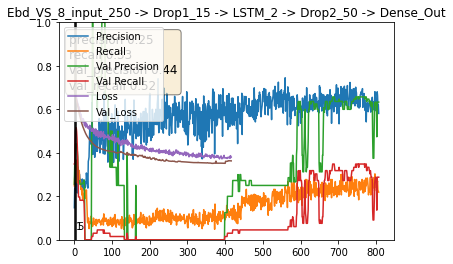

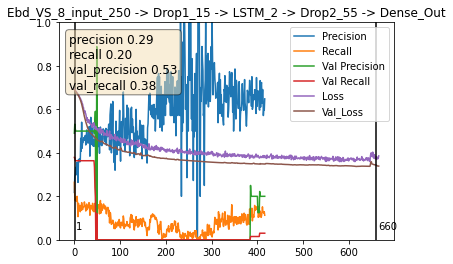

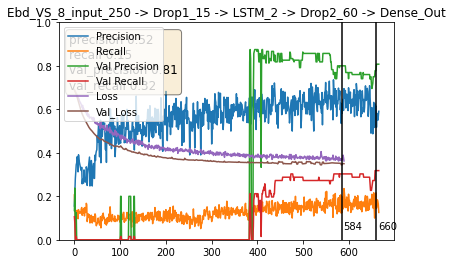

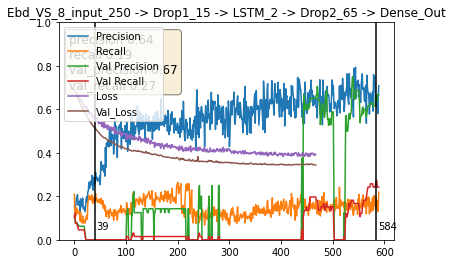

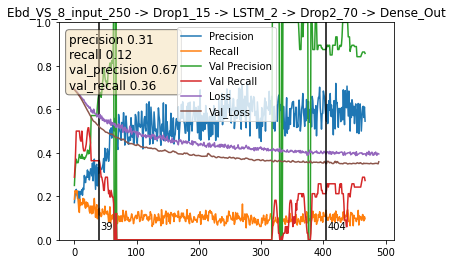

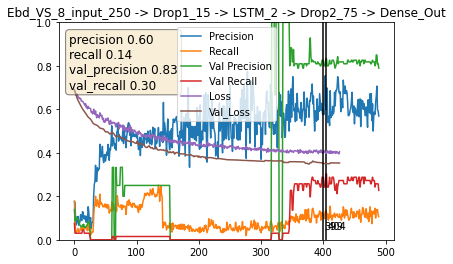

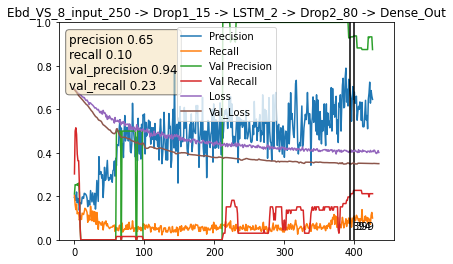

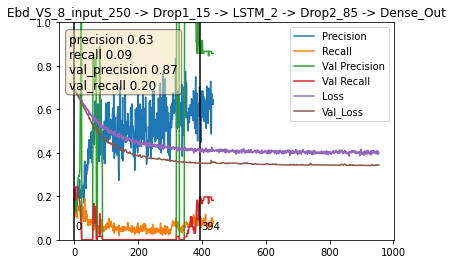

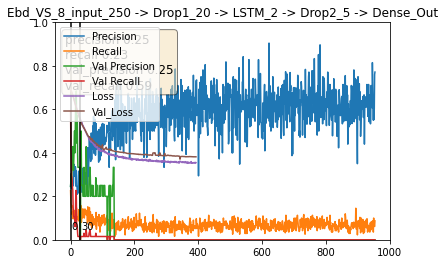

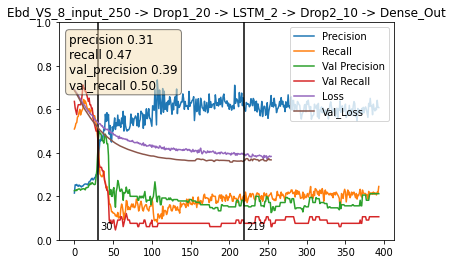

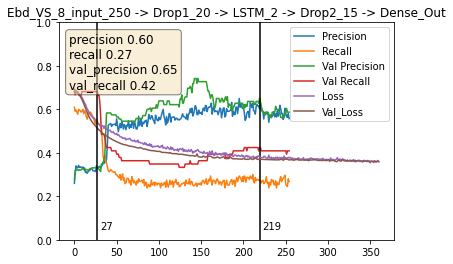

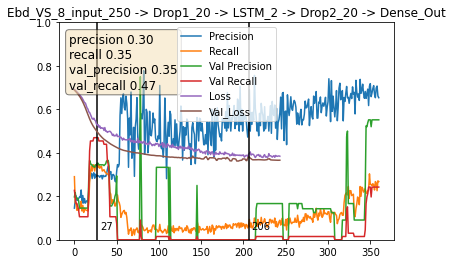

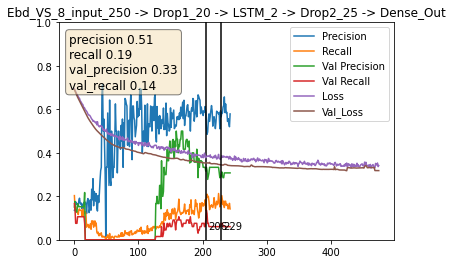

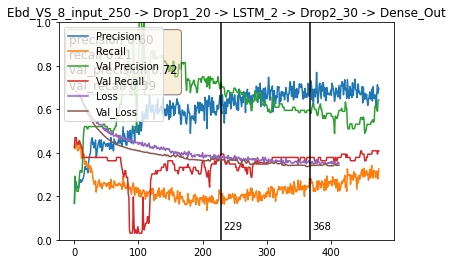

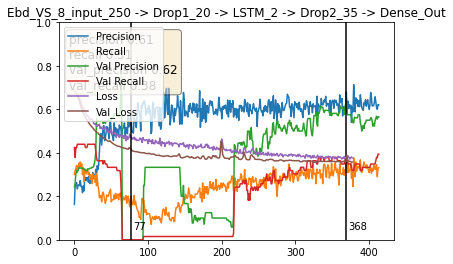

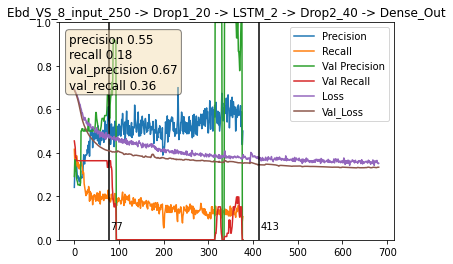

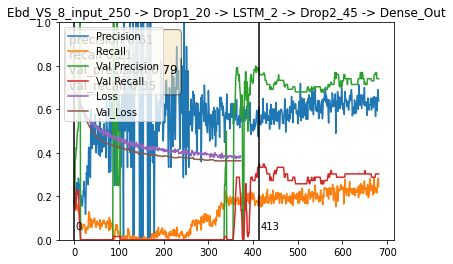

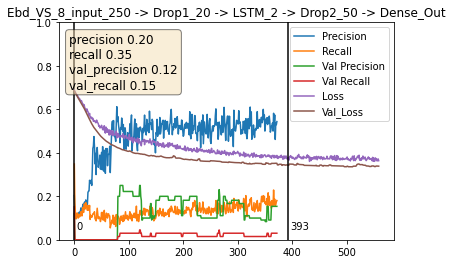

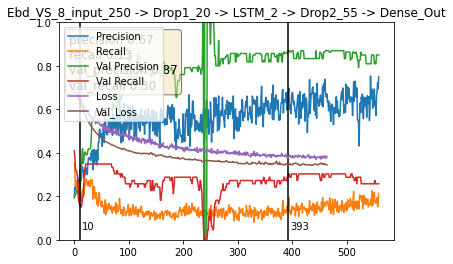

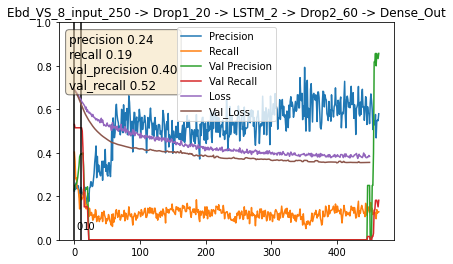

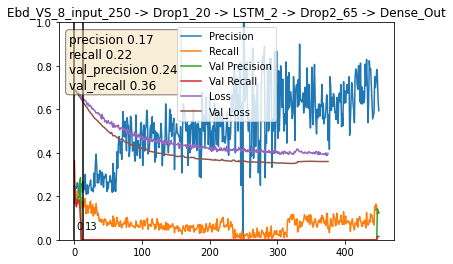

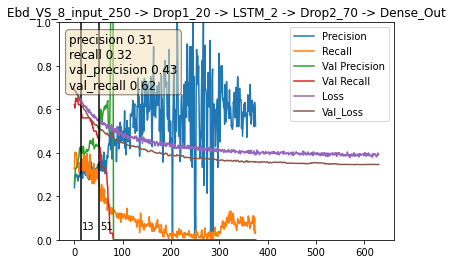

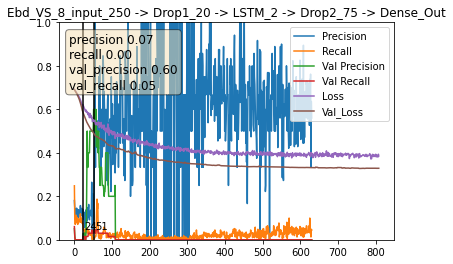

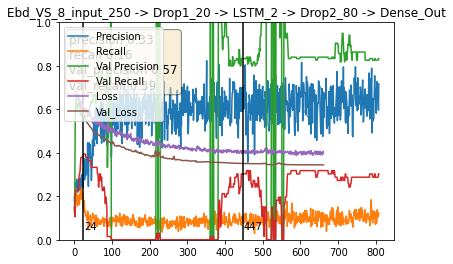

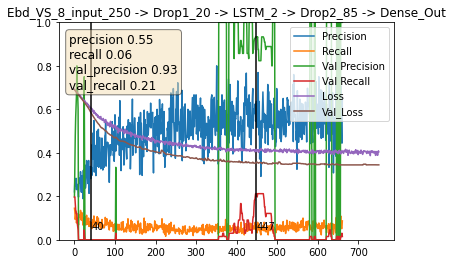

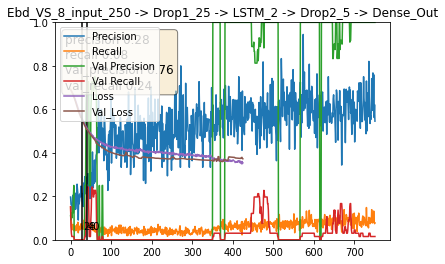

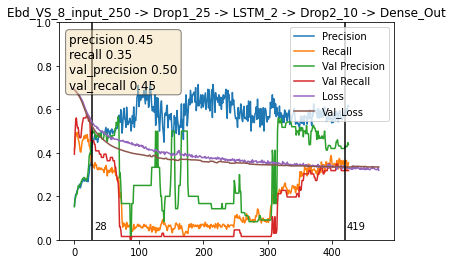

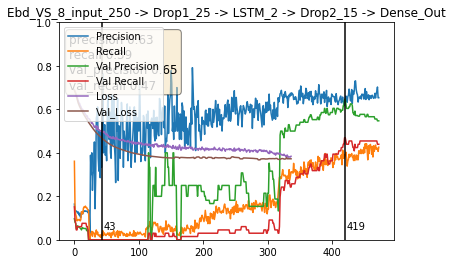

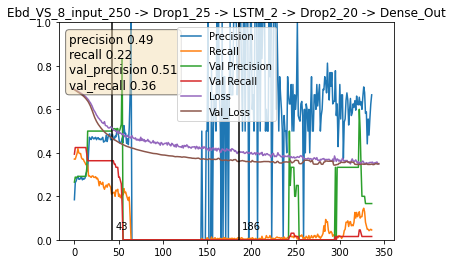

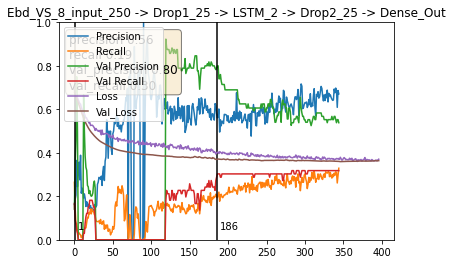

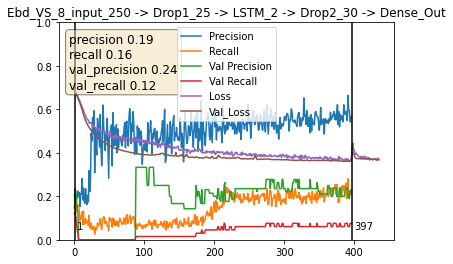

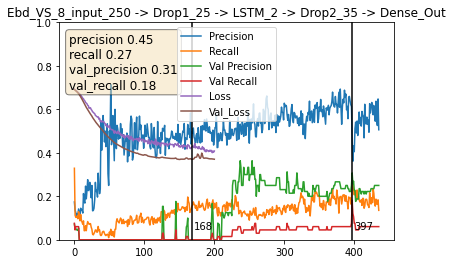

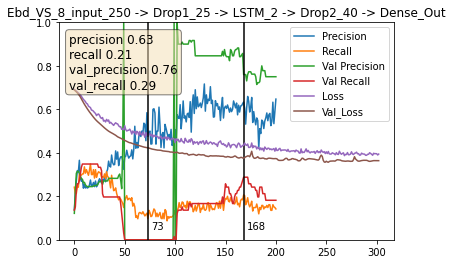

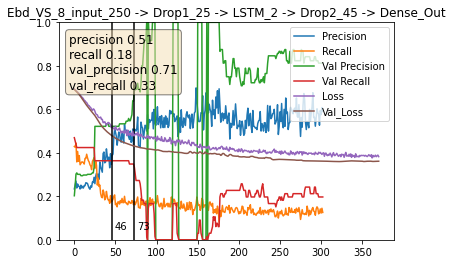

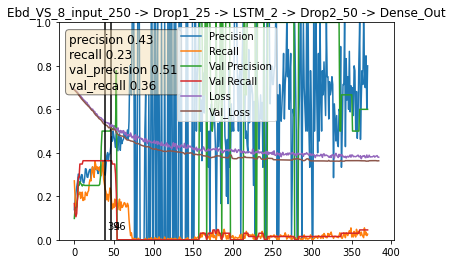

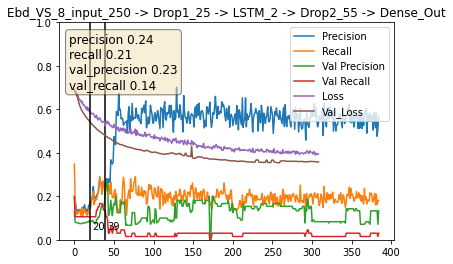

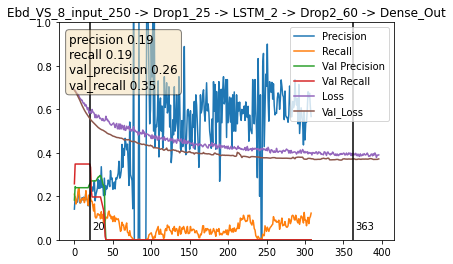

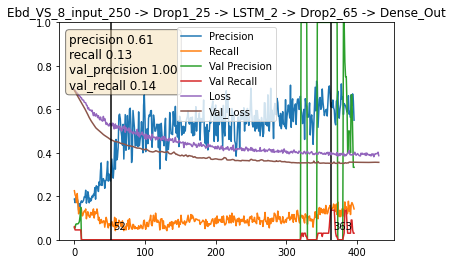

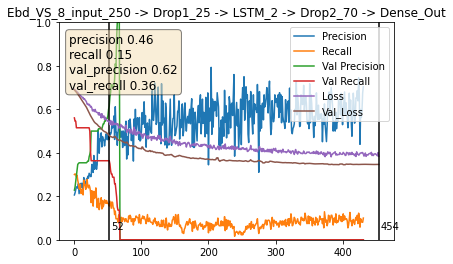

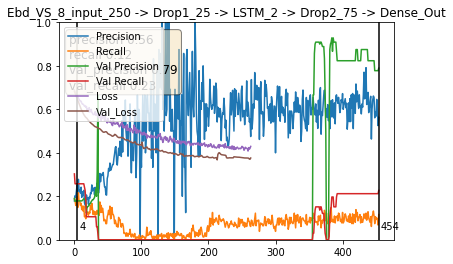

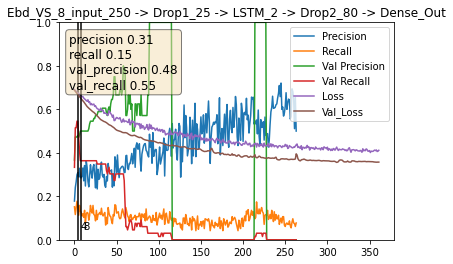

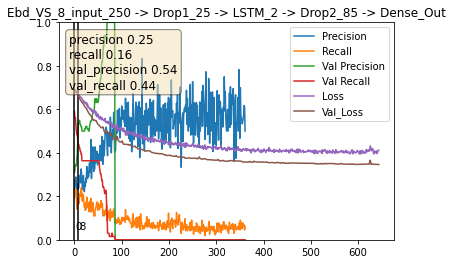

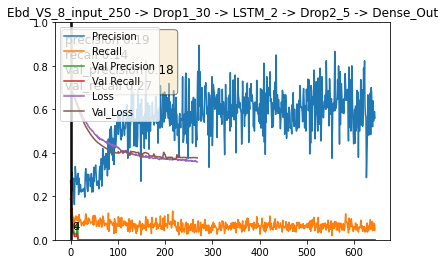

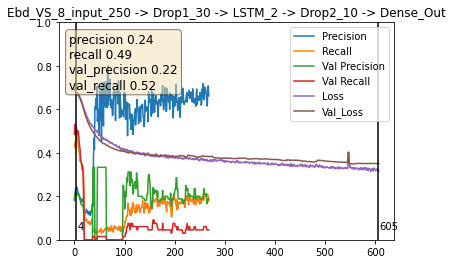

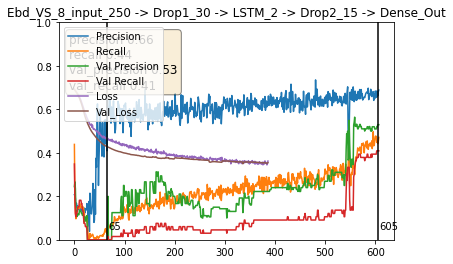

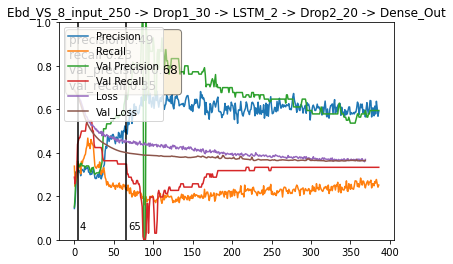

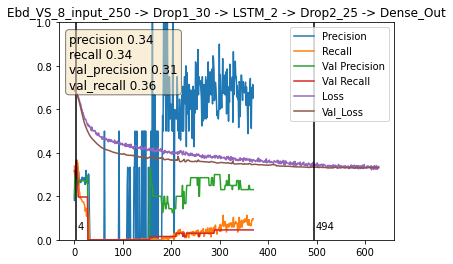

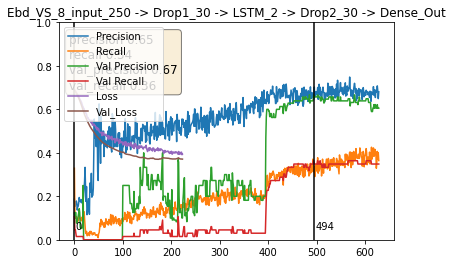

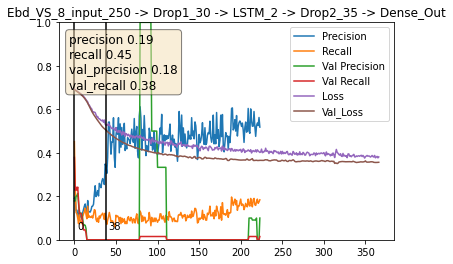

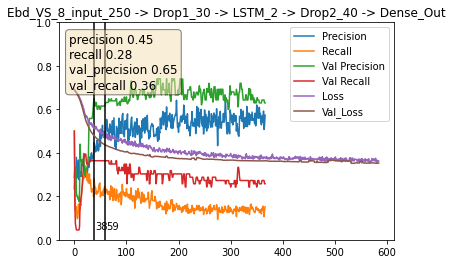

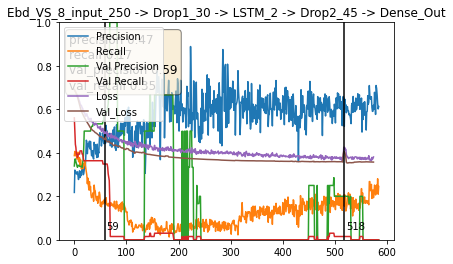

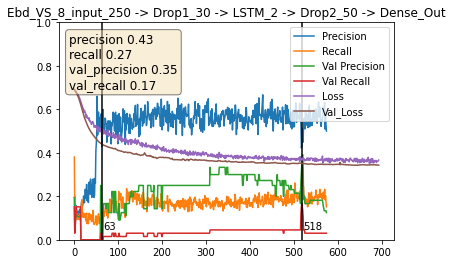

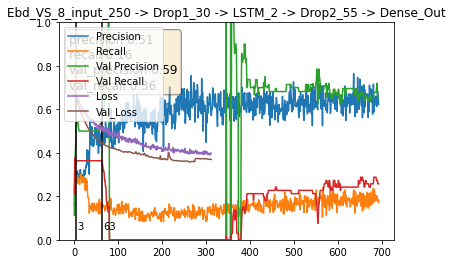

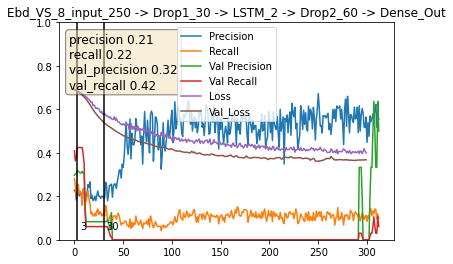

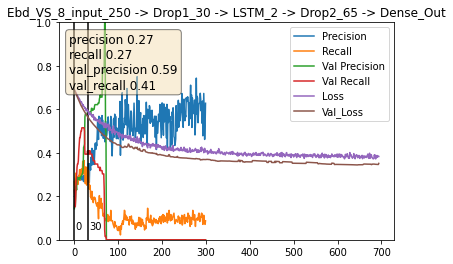

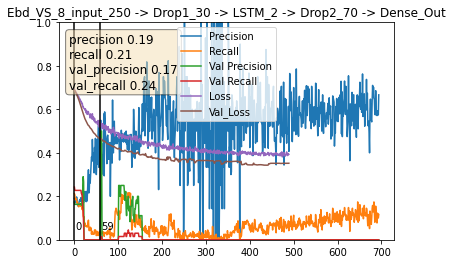

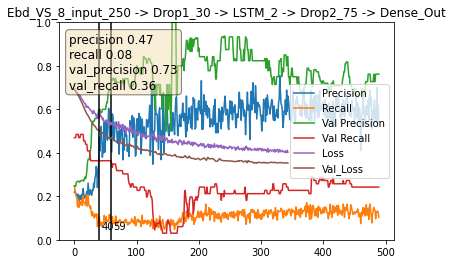

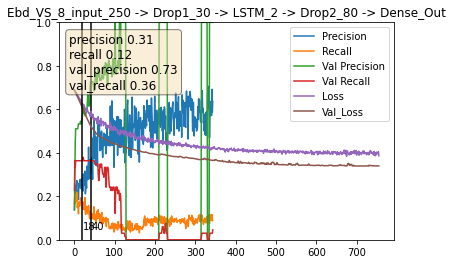

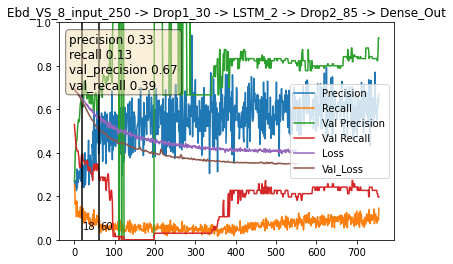

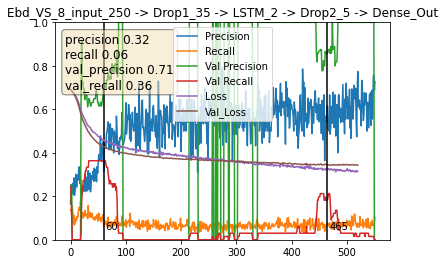

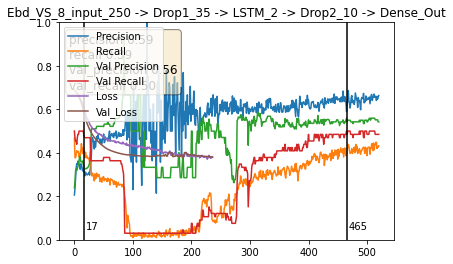

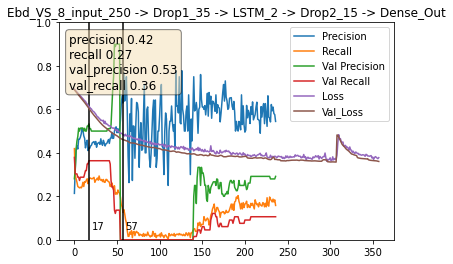

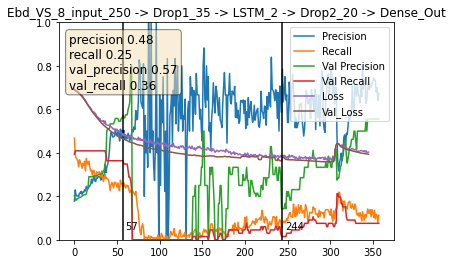

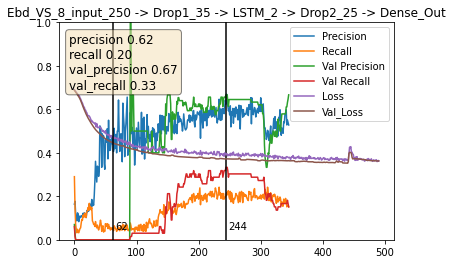

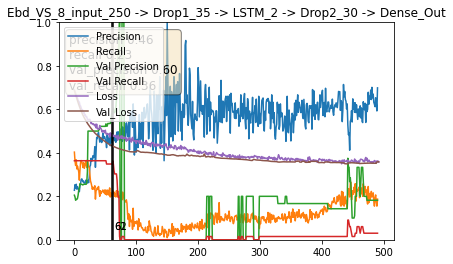

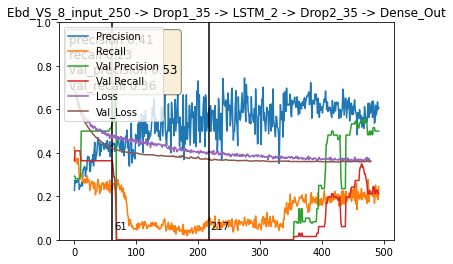

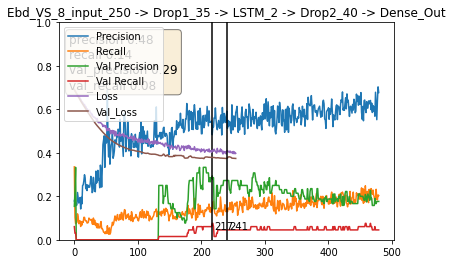

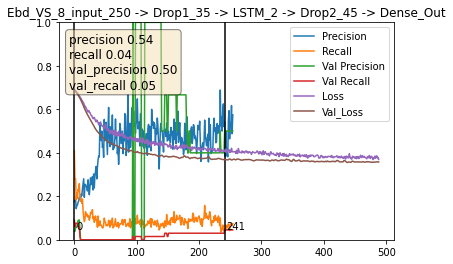

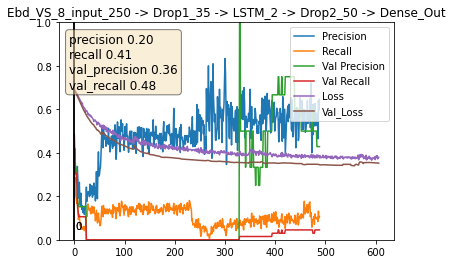

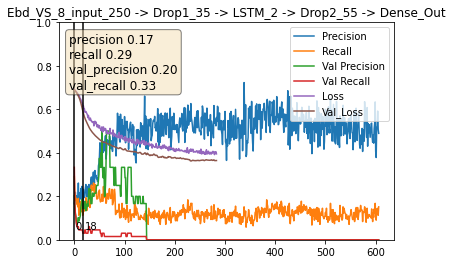

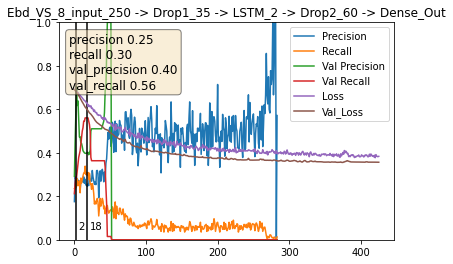

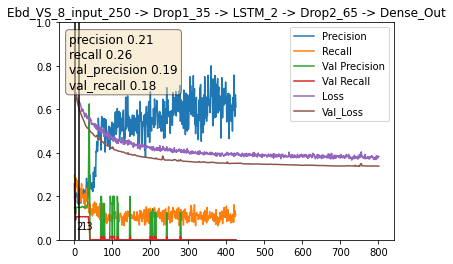

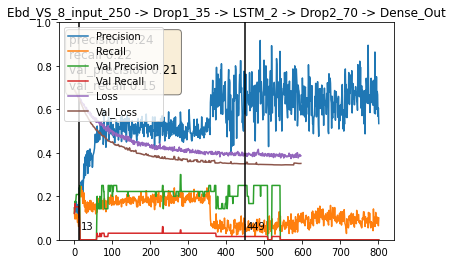

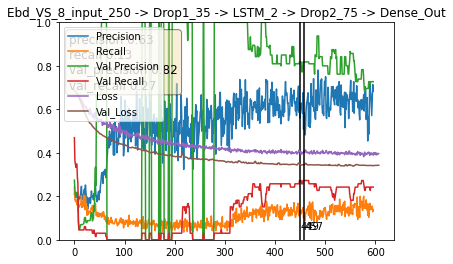

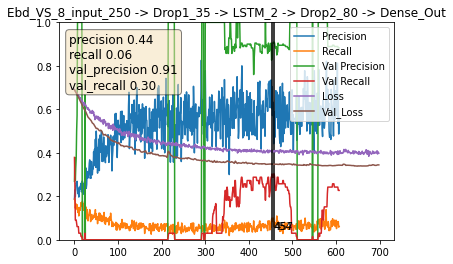

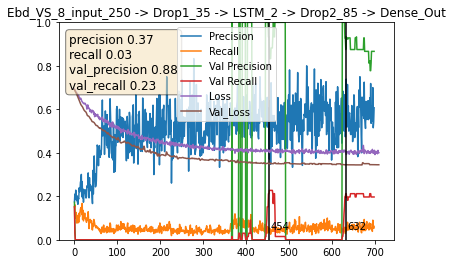

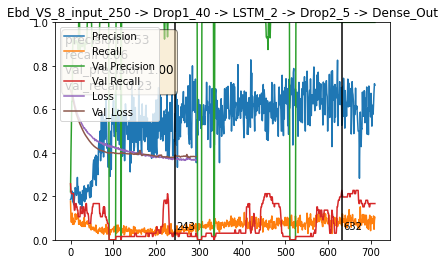

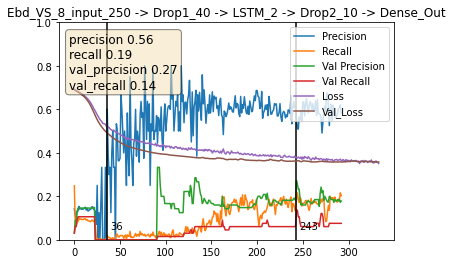

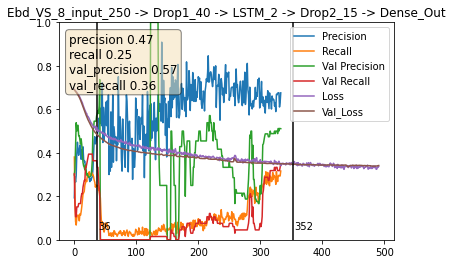

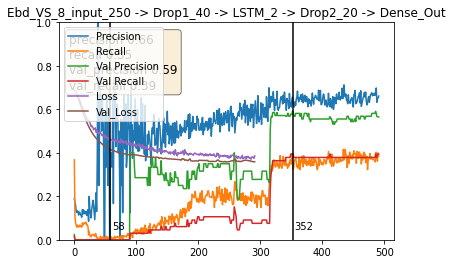

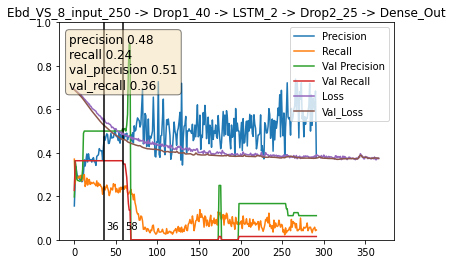

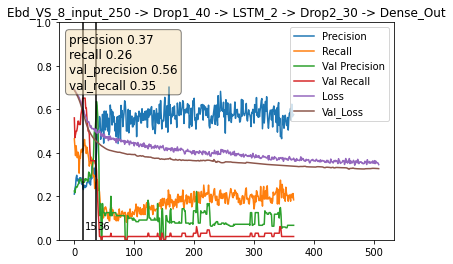

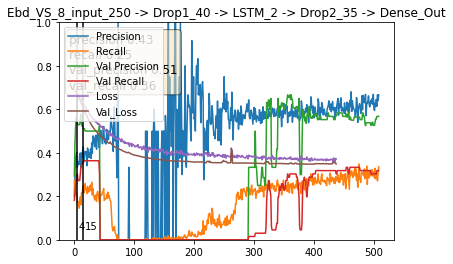

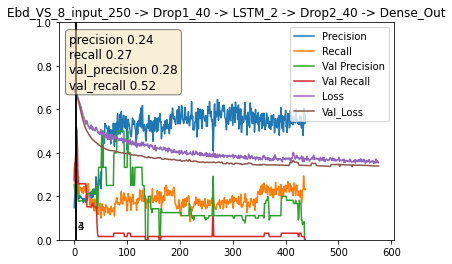

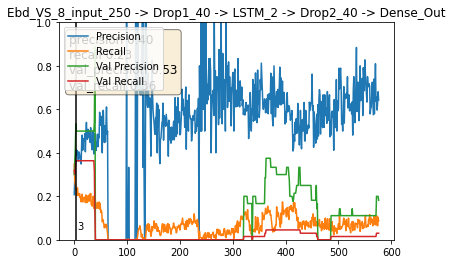

In [ ]:
csv_res = ""
for lstm_num in tqdm(lstm_range):
  for vs in vs_range:
    for d1 in dropout_range:
      for d2 in dropout_range:
        res = test_model(embedding_vector_length=vs, d1_rate=d1, lstm_units=lstm_num, d2_rate=d2)
        csv_results += ','.join([str(i) for i in res]) + "\n"

with open("ml_results/summary.csv", 'w', encoding='utf-8') as f:
  f.write(csv_results)

In [ ]:
# Download all of the results
!zip -r content/lstm_sequence_results.zip /content/ml_results
files.download('lstm_sequence_results.zip')